#### *CSC 180  Intelligent Systems (Spring 2021)*

#### *Dr. Haiquan Chen, Dept of Computer Scicence*

#### *California State University, Sacramento*
<hr>

## Final Project: Panda Runner
### **Team Members:** Quinn Roemer, Logan Hollmer

#### **Description:**
In this project we created various CNN models to a play a game of our own design. In this game, the Deep Learning Neural Network was responsible for determining what action to take based on the current frame being displayed on screen. We treated this as a classification problem with the network capable of determining whether it should either jump, slide, or perform no action. In this game, the player was automatically moving forward at a set rate. The dataset used for this project was custom made and was composed of screenshots taken during gameplay, along with a corresponding label for the correct action to take. We trained both custom CNN models of our own design and models using transfer learning from ``VGG16`` and ``MobileNet``. In order to tune the hyper-parameters of our models we used genetic algorithms. Each model was represented by a "chromosome" which defined cetain hyper-parameter settings. These were then evolved over numerous generations in an attempt to produce the best model.

## Google Colab
Tasks related to Google Colab, mount Google Drive and install the Python library DEAP.

In [1]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Install DEAP
!pip install deap

     |████████████████████████████████| 163kB 9.1MB/s 


## Helpful Tensorflow functions (Little Gems)
The following functions are provided by Dr. Haiquan Chen with a few of our own design. They were used to help streamline our work with Tensorflow by encapsulating common or complex tasks.

In [3]:
# Imports
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import pandas as pd
import shutil
import json
import os

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.optimizers import Adam
from collections.abc import Sequence
from sklearn import preprocessing
from tensorflow import keras
from sklearn import metrics

# Encode text values to dummy variables(i.e. [1,0,0],[0,1,0],[0,0,1] for red,green,blue)
def encode_text_dummy(df, name):
    dummies = pd.get_dummies(df[name])
    for x in dummies.columns:
        dummy_name = "{}-{}".format(name, x)
        df[dummy_name] = dummies[x]
    df.drop(name, axis=1, inplace=True)


# Encode text values to indexes(i.e. [1],[2],[3] for red,green,blue).
def encode_text_index(df, name):
    le = preprocessing.LabelEncoder()
    df[name] = le.fit_transform(df[name])
    return le.classes_


# Encode a numeric column as zscores
def encode_numeric_zscore(df, name, mean=None, sd=None):
    if mean is None:
        mean = df[name].mean()

    if sd is None:
        sd = df[name].std()

    df[name] = (df[name] - mean) / sd


# Convert all missing values in the specified column to the median
def missing_median(df, name):
    med = df[name].median()
    df[name] = df[name].fillna(med)


# Convert all missing values in the specified column to the default
def missing_default(df, name, default_value):
    df[name] = df[name].fillna(default_value)


# Convert a Pandas dataframe to the x,y inputs that TensorFlow needs
def to_xy(df, target):
    result = []
    for x in df.columns:
        if x != target:
            result.append(x)
    # find out the type of the target column. 
    target_type = df[target].dtypes
    target_type = target_type[0] if isinstance(target_type, Sequence) else target_type
    # Encode to int for classification, float otherwise. TensorFlow likes 32 bits.
    if target_type in (np.int64, np.int32):
        # Classification
        dummies = pd.get_dummies(df[target])
        return df[result].values.astype(np.float32), dummies.values.astype(np.float32)
    else:
        # Regression
        return df[result].values.astype(np.float32), df[target].values.astype(np.float32)

# Nicely formatted time string
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return "{}:{:>02}:{:>05.2f}".format(h, m, s)


# Regression chart.
def chart_regression(pred,y,sort=True):
    t = pd.DataFrame({'pred' : pred, 'y' : y.flatten()})
    if sort:
        t.sort_values(by=['y'],inplace=True)
    a = plt.plot(t['y'].tolist(),label='expected')
    b = plt.plot(t['pred'].tolist(),label='prediction')
    plt.ylabel('output')
    plt.legend()
    plt.show()

# Remove all rows where the specified column is +/- sd standard deviations
def remove_outliers(df, name, sd):
    drop_rows = df.index[(np.abs(df[name] - df[name].mean()) >= (sd * df[name].std()))]
    df.drop(drop_rows, axis=0, inplace=True)


# Encode a column to a range between normalized_low and normalized_high.
def encode_numeric_range(df, name, normalized_low=-1, normalized_high=1,
                         data_low=None, data_high=None):
    if data_low is None:
        data_low = min(df[name])
        data_high = max(df[name])

    df[name] = ((df[name] - data_low) / (data_high - data_low)) \
               * (normalized_high - normalized_low) + normalized_low

#Given a dict and a name, save it as a json file
def saveDict(dict, fileName, path='/content/drive/MyDrive/CSC180_Final_Project/saved_dictionaries/'):
    try:
        with open (path + fileName, 'w') as out:
            json.dump(dict, out, indent=4)
        
        out.close()
    except Exception as e:
        print(e)

#Given a file name, load it into a dictionary and return it
def openDict(fileName, path='/content/drive/MyDrive/CSC180_Final_Project/saved_dictionaries/'):
    dict = {}

    try:
        file = open(path + fileName)
        data = json.load(file)
        file.close()
    except Exception as e:
        print(e)

    for (key, value) in data.items():
        dict[key] = value

    return dict

# Plots a confusion matrix   
def plot_confusion_matrix(cm, names, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(names))
    plt.xticks(tick_marks, names, rotation=45)
    plt.yticks(tick_marks, names)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

## Data Preprocessing
In this section, we load our dataset and perform preprocessing. For the purpose of this project, all images will be downsampled to ``(224, 224, 3)`` from their original ``(1280, 720, 3)``. This is the size that our transfer learning models were trained on, and the size that we will use to train our custom CNN models. As previously stated, the dataset we are using was custom built by automatically taking screenshots at varying intervals to capture actions in our game as it was played by us.

Shape: (5095, 224, 224, 3)

Shape: (5095,)

None


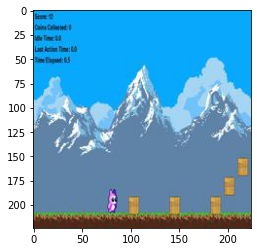

In [4]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

showImage = 0
label_decoder = ['None', 'Jump', 'Slide']

# Load the images
images = np.load('/content/drive/MyDrive/CSC180_Final_Project/images.npy', allow_pickle=True)
print(f'Shape: {images.shape}\n')
plt.imshow(images[showImage])

# Load the labels (0 = None, 1 = W, 2 = S)
labels = np.load('/content/drive/MyDrive/CSC180_Final_Project/labels.npy', allow_pickle=True)
print(f'Shape: {labels.shape}\n')
print(label_decoder[labels[showImage]])

In [5]:
# Perform OHE encoding on the labels
labels = to_categorical(labels, 3)
print(f'Shape: {labels.shape}\n')
print(labels[showImage])

Shape: (5095, 3)

[1. 0. 0.]


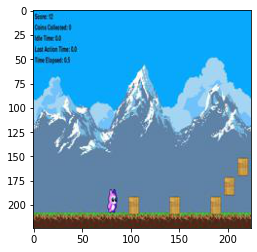

In [6]:
# Convert images to float32 and normalize
images = images.astype('float32')
images /= 255
plt.imshow(images[showImage])

In [7]:
# Create train, test split
x_train, x_test, y_train, y_test = train_test_split(images, labels, test_size=0.25, random_state=42)

print(f'x_train: {x_train.shape}')
print(f'x_test: {x_test.shape}')
print(f'y_train: {y_train.shape}')
print(f'y_test: {y_test.shape}')

x_train: (3821, 224, 224, 3)
x_test: (1274, 224, 224, 3)
y_train: (3821, 3)
y_test: (1274, 3)


## Part 1: Custom CNN Models
Below we define several custom CNN builder functions. Each of these functions accept  a chromosome that is used to create the model. The values in the chromome are as follows: ``["CNN Type", "Activation Function Type", "Optimizer Typer", "Number of Fully-Connected Layers", "Dropout Chance"]``. When training our models in our GA, we will evolve the chromosome to produce the best model.

In [8]:
from keras.layers import Activation, Dropout, Flatten, Dense, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.models import Sequential

# Helper functions
def get_activation_function(x):
  if x % 3 == 0:
    return 'relu'
  elif x % 3 == 1:
    return 'tanh'
  else:
    return 'sigmoid'

def get_optimizer(x):
  if x % 2 == 0:
    return 'adam'
  else:
    return 'sgd'

# CNN One: https://levelup.gitconnected.com/simple-image-classification-with-cnn-dd5ee3b725
def cnn1(chromosome):
  activation_type = get_activation_function(chromosome[1])
  optimizer_type = get_optimizer(chromosome[2])
  dense_layers = chromosome[3] + 2
  dropout_chance = float(chromosome[4])/float(13)

  # Create the model
  model = Sequential()
  model.add(Conv2D(32, (3, 3), input_shape=(224, 224, 3)))
  model.add(Activation(activation_type))
  model.add(MaxPooling2D(pool_size=(2, 2), padding = 'same'))

  model.add(Conv2D(64, (3, 3)))
  model.add(Activation(activation_type))
  model.add(MaxPooling2D(pool_size=(2, 2)))

  model.add(Conv2D(128, (3, 3)))
  model.add(Activation(activation_type))
  model.add(MaxPooling2D(pool_size=(2, 2)))

  model.add(Flatten())

  # Add the dense layers
  for x in range(dense_layers):
    model.add(Dense(pow(2, dense_layers + 1 - x), activation=activation_type))
    model.add(Dropout(dropout_chance))

  # Add the output layer
  model.add(Dense(3, activation='softmax'))

  # Compile the model
  model.compile(loss='categorical_crossentropy', optimizer=optimizer_type, metrics=['accuracy'])
  return model

# CNN Two: https://towardsdatascience.com/the-4-convolutional-neural-network-models-that-can-classify-your-fashion-images-9fe7f3e5399d
def cnn2(chromosome):
  activation_type = get_activation_function(chromosome[1])
  optimizer_type = get_optimizer(chromosome[2])
  dense_layers = chromosome[3] + 2
  dropout_chance = float(chromosome[4])/float(13)

  # Create the model
  model = Sequential()
  model.add(Conv2D(32, kernel_size=(3, 3), activation=activation_type, input_shape=(224, 224, 3)))
  model.add(BatchNormalization())

  model.add(Conv2D(32, kernel_size=(3, 3), activation=activation_type))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(dropout_chance))

  model.add(Conv2D(64, kernel_size=(3, 3), activation=activation_type))
  model.add(BatchNormalization())
  model.add(Dropout(dropout_chance))

  model.add(Conv2D(128, kernel_size=(3, 3), activation=activation_type))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(dropout_chance))

  model.add(Flatten())

  # Add the dense layers
  for x in range(dense_layers):
    model.add(Dense(pow(2, dense_layers + 1 - x), activation=activation_type))
    model.add(Dropout(dropout_chance))

  # Add the output layer
  model.add(Dense(3, activation='softmax'))

  # Compile the model
  model.compile(loss='categorical_crossentropy', optimizer=optimizer_type, metrics=['accuracy'])
  return model

# CNN Three: Of my own design
def cnn3(chromosome):
  activation_type = get_activation_function(chromosome[1])
  optimizer_type = get_optimizer(chromosome[2])
  dense_layers = chromosome[3] + 2
  dropout_chance = float(chromosome[4])/float(13)

  # Create the model
  model = Sequential()
  model.add(Conv2D(32, kernel_size=(3, 3), strides=(2, 2), input_shape=(224, 224, 3), activation=activation_type))
  model.add(Conv2D(64, kernel_size=(3, 3), strides=(2, 2), activation=activation_type))
  model.add(MaxPooling2D(pool_size=(2, 2)))

  model.add(Conv2D(128, kernel_size=(3, 3), strides=(2, 2), activation=activation_type))
  model.add(MaxPooling2D(pool_size=(2, 2)))

  model.add(GlobalAveragePooling2D())

  # Add the dense layers
  for x in range(dense_layers):
    model.add(Dense(pow(2, dense_layers + 1 - x), activation=activation_type))
    model.add(Dropout(dropout_chance))

  # Add the output layer
  model.add(Dense(3, activation='softmax'))

  # Compile the model
  model.compile(loss='categorical_crossentropy', optimizer=optimizer_type, metrics=['accuracy'])
  return model

#Print the models
chromosome = [1, 2, 4, 3, 5]

print('Custom CNN 1:\n')
model = cnn1(chromosome)
print(f'{model.summary()}\n\n')

print('Custom CNN 2:\n')
model = cnn2(chromosome)
print(f'{model.summary()}\n\n')

print('Custom CNN 3:\n')
model = cnn3(chromosome)
print(f'{model.summary()}\n\n')

Custom CNN 1:

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 222, 222, 32)      896       
_________________________________________________________________
activation (Activation)      (None, 222, 222, 32)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 111, 111, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 109, 109, 64)      18496     
_________________________________________________________________
activation_1 (Activation)    (None, 109, 109, 64)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 54, 54, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 52, 5

## GA Evalution Function
After defining our models, we will need to create a function to evaluate a chromosome. This function will be responsible for training the model, saving certain items related to that model, and returning the F1 score of that particular trained model as the evalution. In addition to this, we will save chromosome that have already been tested in a dictionary to prevent the same chromosome from being trained multiple times.

In [ ]:
#Create a dictionary of the models that have been already evaluated
import os

seen_models=None

if (os.path.exists('/content/drive/MyDrive/CSC180_Final_Project/saved_dictionaries_custom_cnn/Evaluated_Models_Custom_CNN.json')):
  seen_models=openDict('Evaluated_Models_Custom_CNN.json', path='/content/drive/MyDrive/CSC180_Final_Project/saved_dictionaries_custom_cnn/')
else:
  seen_models={}

print(seen_models)

{'[6, 2, 4, 1, 6]': 0.3377031557765229, '[4, 2, 5, 1, 2]': 0.8071872892752893, '[1, 2, 6, 5, 4]': 0.3377031557765229, '[3, 4, 5, 6, 1]': 0.8143833295581191, '[4, 2, 6, 3, 6]': 0.3377031557765229, '[2, 3, 1, 3, 4]': 0.3377031557765229, '[4, 4, 1, 5, 6]': 0.3377031557765229, '[1, 6, 5, 3, 3]': 0.3377031557765229, '[2, 6, 5, 4, 4]': 0.3377031557765229, '[5, 5, 1, 1, 4]': 0.3377031557765229, '[1, 6, 4, 1, 2]': 0.3377031557765229, '[4, 5, 6, 6, 5]': 0.3377031557765229, '[1, 2, 2, 5, 2]': 0.3377031557765229, '[2, 3, 3, 2, 2]': 0.3377031557765229, '[1, 5, 1, 3, 6]': 0.3377031557765229, '[6, 3, 2, 2, 5]': 0.7219013226133286, '[5, 5, 6, 5, 3]': 0.3377031557765229, '[1, 6, 3, 2, 1]': 0.5480895894676187, '[3, 4, 6, 4, 3]': 0.3377031557765229, '[1, 3, 1, 1, 4]': 0.3377031557765229, '[1, 6, 5, 1, 2]': 0.3377031557765229, '[1, 6, 4, 3, 3]': 0.38668664568507743, '[6, 2, 5, 1, 5]': 0.3377031557765229, '[4, 3, 2, 2, 4]': 0.06415591403484866, '[1, 5, 4, 3, 6]': 0.3377031557765229, '[5, 4, 5, 6, 1]': 0.3

In [ ]:
#Helper function decodes the CNN type asked for in the chromosome
def get_CNN_type(chromosome):
  if chromosome[0] % 3 == 0:
    print('CNN Type 1\n')
    model = cnn1(chromosome)
    return model
  elif chromosome[0] % 3 == 1:
    print('CNN Type 2\n')
    model = cnn2(chromosome)
    return model
  else:
    print('CNN Type 3\n')
    model = cnn3(chromosome)
    return model

#Evaluation function for DEAP
def evaFitness(chromosome):
  #Check if this model has been evaluated... if so return the previous score
  modelStr = str(chromosome)
  if modelStr in seen_models:
    return (seen_models[modelStr],)

  #Else, create this model and train it
  print('Training: ' + modelStr)

  #Make the directory to save the model
  if not os.path.exists('/content/drive/MyDrive/CSC180_Final_Project/Custom_CNN_Models/' + modelStr):
    os.mkdir('/content/drive/MyDrive/CSC180_Final_Project/Custom_CNN_Models/' + modelStr)

  #Create checkpoints
  monitor = EarlyStopping(monitor='val_loss', min_delta=1e-4, patience=4, verbose=2, mode='auto')
  checkpointer = ModelCheckpoint(filepath='/content/drive/MyDrive/CSC180_Final_Project/Custom_CNN_Models/' + modelStr + '/best_weights.hdf5', verbose=0, save_best_only=True)

  #Determine the CNN type to build
  model = get_CNN_type(chromosome)

  #Train the model
  model.fit(x_train, y_train, batch_size=32, epochs=1000, verbose=1, validation_data=(x_test, y_test), callbacks=[monitor, checkpointer])

  #Load the best weights
  model.load_weights('/content/drive/MyDrive/CSC180_Final_Project/Custom_CNN_Models/' + modelStr + '/best_weights.hdf5')

  #Score the model
  pred = model.predict(x_test)
  pred = np.argmax(pred, axis=1)
  y_true = np.argmax(y_test, axis=1)
  f1 = metrics.f1_score(y_true, pred, average='weighted')
  
  #Record the model as seen
  seen_models[modelStr] = f1

  #Save the model classification score in the folder
  scoreFile = open('/content/drive/MyDrive/CSC180_Final_Project/Custom_CNN_Models/' + modelStr + '/classification_score.txt', 'w')
  scoreFile.write(metrics.classification_report(y_true, pred, zero_division=1))
  scoreFile.close()

  #Save the models confusion matrix plot
  cm = confusion_matrix(y_true, pred)
  plt.figure()
  plot_confusion_matrix(cm, label_decoder)
  plt.savefig('/content/drive/MyDrive/CSC180_Final_Project/Custom_CNN_Models/' + modelStr + '/CM.png')
  plt.close()

  #Return the models eval
  print(f'F1 Score: {f1}\n')
  return (f1,)

## Setup & Run GA
After defining our evalution function we are ready to create and run our GA. We will use the Python libray DEAP to facilitate this process. The strategies that we picked for our GA our listed below:
* **Mate:** Two Point Crossover (``cxTwoPoint()``)
* **Mutation:** Uniform Int (``mutUniformInt()``)
* **Selection:** Tournament (``selTournament()``)

In [ ]:
import random
import numpy as np
from deap import algorithms, base, creator, tools

creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", list, fitness=creator.FitnessMax)

In [ ]:
#Creator function to generate our individuals
def create_individual():
  individual = []
  for x in range(5):
    individual.append(random.randint(1, 6))

  return individual

In [ ]:
#Define our toolbox
toolbox = base.Toolbox()
toolbox.register("individual", tools.initIterate, creator.Individual, create_individual)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

#Register strategies
toolbox.register("evaluate", evaFitness)
toolbox.register("mate", tools.cxTwoPoint)
toolbox.register("mutate", tools.mutUniformInt, low = 1, up = 6, indpb=0.1)
toolbox.register("select", tools.selTournament, tournsize=3)

#Statistics
stats = tools.Statistics(key=lambda ind: ind.fitness.values)
stats.register("avg", np.mean)
stats.register("max", np.max)

In [ ]:
#Define population and hall of fame
pop = toolbox.population(n=20)
hof = tools.HallOfFame(maxsize=1)

#Run the GA
pop, log = algorithms.eaSimple(pop, toolbox, cxpb=0.5, mutpb=0.2, ngen=15, stats=stats, halloffame=hof, verbose=True)

#Save the dictionary
saveDict(seen_models, 'Evaluated_Models_Custom_CNN.json', path='/content/drive/MyDrive/CSC180_Final_Project/saved_dictionaries_custom_cnn/')

Training: [6, 5, 6, 3, 3]
CNN Type 1

Epoch 1/1000
120/120 [==============================] - 6s 40ms/step - loss: 1.1993 - accuracy: 0.2801 - val_loss: 1.0532 - val_accuracy: 0.5039
Epoch 2/1000
120/120 [==============================] - 4s 37ms/step - loss: 1.0673 - accuracy: 0.4536 - val_loss: 1.0279 - val_accuracy: 0.5039
Epoch 3/1000
120/120 [==============================] - 4s 37ms/step - loss: 1.0416 - accuracy: 0.4904 - val_loss: 1.0260 - val_accuracy: 0.5039
Epoch 4/1000
120/120 [==============================] - 4s 37ms/step - loss: 1.0539 - accuracy: 0.4800 - val_loss: 1.0250 - val_accuracy: 0.5039
Epoch 5/1000
120/120 [==============================] - 4s 37ms/step - loss: 1.0417 - accuracy: 0.4967 - val_loss: 1.0249 - val_accuracy: 0.5039
Epoch 6/1000
120/120 [==============================] - 4s 37ms/step - loss: 1.0391 - accuracy: 0.5040 - val_loss: 1.0250 - val_accuracy: 0.5039
Epoch 7/1000
120/120 [==============================] - 4s 37ms/step - loss: 1.0346 - accura

## Results
Below you can find the generational improvement plot as well as information on the best model created.

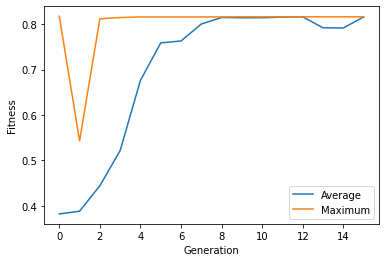

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline  

#Show generational plot
gen, avg, max_ = log.select("gen", "avg", "max")
plt.plot(gen, avg, label="Average")
plt.plot(gen, max_, label="Maximum")
plt.xlabel("Generation")
plt.ylabel("Fitness")
plt.legend(loc="lower right")
plt.show()

In [ ]:
#Print best score and individual
print(f'Best Individual:\n{hof[0]}')
print(f'Fitness: {seen_models[str(hof[0])]}')

Best Individual:
[4, 3, 5, 1, 1]
Fitness: 0.817283523009102


Model Info:
CNN Type: 2
Activation Type: relu
Optimizer Type: sgd
Number of Fully-Connected Layers: 3 (not including output layer)
Dropout Chance: 0.07692307692307693

Model Report:
              precision    recall  f1-score   support

           0       0.83      0.80      0.82       642
           1       0.76      0.76      0.76       387
           2       0.88      0.94      0.91       245

    accuracy                           0.82      1274
   macro avg       0.82      0.84      0.83      1274
weighted avg       0.82      0.82      0.82      1274



Plot:


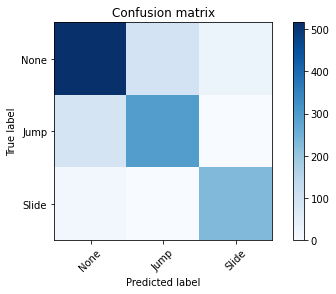

In [22]:
chromosome = [4, 3, 5, 1, 1]

def get_model_type(x):
  if chromosome[0] % 3 == 0:
    return 1
  elif chromosome[0] % 3 == 1:
    return 2
  else:
    return 3

# Load the model
model = tf.keras.models.load_model(f'/content/drive/MyDrive/CSC180_Final_Project/Custom_CNN_Models/{chromosome}/best_weights.hdf5')

# Print model info
print('Model Info:')
print(f'CNN Type: {get_model_type(chromosome[0])}')
print(f'Activation Type: {get_activation_function(chromosome[1])}')
print(f'Optimizer Type: {get_optimizer(chromosome[2])}')
print(f'Number of Fully-Connected Layers: {chromosome[3] + 2} (not including output layer)')
print(f'Dropout Chance: {float(chromosome[4])/float(13)}\n')

# Predict
pred = model.predict(x_test)
pred = np.argmax(pred, axis=1)
y_true = np.argmax(y_test, axis=1)

# Report
print('Model Report:')
print(metrics.classification_report(y_true, pred, zero_division=1))
print('\n')

# Plot
print('Plot:')
cm = confusion_matrix(y_true, pred)
plt.figure()
plot_confusion_matrix(cm, label_decoder)

## Part 2: Transfer Learning Models
After training our custom CNN models we will now train our models that incorporate transfer learning. As before the hyper-parameters for each model will be defined in a chromosome. However, this chromosome differs slightly from the one used above. The values in this chromosome are as follows: ``["Optimizer Type", "Activation Function Type", "Number of Trainable Layers", "Dropout Chance", "Number of Dense Layers", "Model Type"]``. This chromosome we be used in our GA to tune our hyper-parameters to help produce the best model.

In [ ]:
from tensorflow.keras.layers import UpSampling2D, GlobalAveragePooling2D
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras import layers

# Builder function for VGG16
def build_transfer_model_VGG(chromosome):
    vgg_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    activation_function=None
    optimizer_function=None
    dropout_chance=float(chromosome[3])/float(13)

    # Determine activation type
    if (chromosome[1]%3==0):
        activation_function="relu"
    elif (chromosome[1]%3==1):
        activation_function="tanh"
    elif (chromosome[1]%3==2):
        activation_function="sigmoid"

    # Determine optimizer type
    if (chromosome[0]%2==0):
        optimizer_function="adam"
    else:
        optimizer_function="sgd"

    # Create our model
    model = Sequential()

    # Add VGG16 layers
    for layer in vgg_model.layers:
        model.add(layer)

    # Freeze the number of layers defined by the chromosome
    for layer in model.layers[:len(model.layers)-chromosome[2]]:
        layer.trainable= False

    model.add(Flatten())

    # Add Fully-Connected portion of the network
    for i in range(chromosome[4]+2):
        model.add(Dense(pow(2,chromosome[4]+1-i), activation=activation_function))
        model.add(Dropout(dropout_chance))

    # Add output layer, compile, and return model
    model.add(Dense(3, activation='softmax'))
    model.compile(loss="categorical_crossentropy", optimizer=optimizer_function)
    return model

# Builder function for MobileNet
def build_transfer_model_mobile(chromosome):
    mobile_model = MobileNetV2(weights='imagenet',include_top=False, input_shape=(224, 224, 3))
    activation_function=None
    optimizer_function=None
    dropout_chance=float(chromosome[3])/float(13)

    # Determine activation type
    if (chromosome[1]%3==0):
        activation_function="relu"
    elif (chromosome[1]%3==1):
        activation_function="tanh"
    elif (chromosome[1]%3==2):
        activation_function="sigmoid"

    # Determine optimizer type
    if (chromosome[0]%2==0):
        optimizer_function="adam"
    else:
        optimizer_function="sgd"

    # Freeze the number of layers defined by the chromosome
    for layer in mobile_model.layers[:len(mobile_model.layers)-chromosome[2]]: #set the number of trainable layers
        layer.trainable= False
    
    # Add a some top layers
    newOut = mobile_model.output
    newOut = GlobalAveragePooling2D()(newOut)

    # Add the fully connected portion of the network
    for i in range(chromosome[4]+2):
        newOut = Dense(pow(2,chromosome[4]+1-i), activation=activation_function)(newOut)
        newOut = Dropout(dropout_chance)(newOut)

    # Create the output layer
    newOut = Dense(3, activation='softmax')(newOut) #Perm

    #Create model, compile, and return it
    model = Model(inputs=mobile_model.input, outputs=newOut)
    model.compile(loss="categorical_crossentropy", optimizer=optimizer_function)
    return model

#Print model examples
chromosome = [0, 0, 1, 5, 9]

print('VGG16 Model:\n')
model = build_transfer_model_VGG(chromosome)
print(f'{model.summary()}\n\n')

print('MobileNet Model:\n')
model = build_transfer_model_mobile(chromosome)
print(f'{model.summary()}\n\n')

VGG16 Model:

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 56, 

## GA Evaluation Function
After defining our transfer learning models, we will need to create our evaluation function. This will be very similiar to our evaluation function for our custom CNN models. As before certain items related to that model will be saved. The F1 score of that particular trained model will act as its evaluation. Chromosomes will be saved in a dictionary so as to not train the same chromosome multiple times.

In [ ]:
#Create dictorary of already evaluated model:
import os

seen_models=None

if (os.path.exists("/content/drive/MyDrive/CSC180_Final_Project/saved_dictionaries_transfer_learning/Evaluated_Models_Transfer_Learning.json")):
  seen_models=openDict("Evaluated_Models_Transfer_Learning.json", path="/content/drive/MyDrive/CSC180_Final_Project/saved_dictionaries_transfer_learning/")
else:
  seen_models={}

print(seen_models)
best_f1=0

{'[3, 9, 9, 9, 4, 1]': 0.3377031557765229, '[6, 5, 6, 5, 4, 6]': 0.3377031557765229, '[7, 8, 2, 7, 1, 1]': 0.3377031557765229, '[5, 7, 4, 4, 4, 6]': 0.544804381763419, '[3, 1, 6, 4, 8, 6]': 0.5334904894966727, '[8, 6, 5, 9, 0, 4]': 0.3377031557765229, '[0, 1, 5, 6, 4, 5]': 0.3377031557765229, '[1, 8, 6, 3, 1, 2]': 0.3377031557765229, '[6, 2, 0, 8, 7, 3]': 0.3377031557765229, '[8, 2, 1, 8, 6, 9]': 0.3377031557765229, '[9, 5, 1, 4, 7, 3]': 0.3377031557765229, '[1, 3, 9, 1, 3, 5]': 0.8179360998043937, '[5, 4, 3, 9, 0, 9]': 0.3377031557765229, '[1, 5, 9, 0, 2, 8]': 0.5434526534800941, '[6, 4, 3, 9, 2, 6]': 0.3896457014127283, '[5, 9, 4, 9, 5, 6]': 0.3377031557765229, '[3, 5, 8, 1, 3, 1]': 0.3377031557765229, '[7, 1, 0, 3, 4, 2]': 0.5366182170832514, '[3, 6, 8, 6, 2, 7]': 0.3377031557765229, '[9, 2, 0, 4, 5, 8]': 0.3377031557765229, '[8, 5, 8, 1, 6, 9]': 0.3377031557765229, '[3, 2, 1, 8, 3, 1]': 0.3377031557765229, '[5, 9, 9, 9, 5, 6]': 0.3377031557765229, '[3, 9, 4, 9, 4, 1]': 0.3377031557

In [ ]:
best=0

# Evaluation function for DEAP
def evaFitness(individual):
    # Check if this model has been evaluated... if so return the previous score
    model_as_string=str(individual)
    if model_as_string in seen_models:
        return (seen_models[model_as_string],)

    # Else, create the model and train it
    print("Training: ", model_as_string)

    # Create checkpoints
    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-4, patience=4, verbose=1, mode='auto')
    checkpointer = ModelCheckpoint(filepath='dnn/best_weights.hdf5', verbose=0, save_best_only=True)

    # Get model
    if (individual[5]%2==0):
        model=build_transfer_model_mobile(individual)
    else:
        model=build_transfer_model_VGG(individual)

    # Train the model
    model.fit(x_train, y_train,     
            batch_size=32,
            epochs=1000,
            verbose=1,
            validation_data=(x_test, y_test),
            callbacks=[monitor, checkpointer])

    # Load the best model
    model.load_weights('dnn/best_weights.hdf5')

    # Score the model
    pred = model.predict(x_test)
    pred = np.argmax(pred,axis=1)
    y_true = np.argmax(y_test,axis=1)
    f1 = metrics.f1_score(y_true, pred, average='weighted')

    # Save the model if it scores above a certain score
    if (f1>0.7):
        best=f1
        model.save('/content/drive/MyDrive/CSC180_Final_Project/Transfer_Learning_Models/Run_2_f1_'+str(f1)+"_"+model_as_string)

    # Record the model as seen
    seen_models[model_as_string]=f1

    # Return evaluation
    return (f1,)

## Setup & Run GA
After defining our evaluation function for our transfer learning models we are ready to create and run our GA. As before DEAP will be used to facilate this process. The same strategies we used for our custom CNN models will be used.

In [ ]:
import random
import numpy as np
from deap import algorithms, base, creator, tools

creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", list, fitness=creator.FitnessMax)

In [ ]:
# Define our toolbox
toolbox = base.Toolbox()
toolbox.register("attr_int", random.randint, 0, 9)
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_int, n=6)

#Register strategies
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("evaluate", evaFitness)
toolbox.register("mate", tools.cxTwoPoint)
toolbox.register("mutate", tools.mutUniformInt, low = 0, up = 9, indpb=0.1)
toolbox.register("select", tools.selTournament, tournsize=3)

#Statistics
stats = tools.Statistics(key=lambda ind: ind.fitness.values)
stats.register("avg", np.mean)
stats.register("max", np.max)

In [ ]:
#Define population and hall of fame
pop = toolbox.population(n=20)
hof = tools.HallOfFame(maxsize=1)

#Run the GA
pop, log = algorithms.eaSimple(pop, toolbox, cxpb=0.2, mutpb=0.7, ngen=15, stats=stats, halloffame=hof, verbose=True)

#Save the dictionary
saveDict(seen_models, "Evaluated_Models_Transfer_Learning.json", path="/content/drive/MyDrive/CSC180_Final_Project/saved_dictionaries_transfer_learning/")

Streaming output truncated to the last 5000 lines.
120/120 [==============================] - 12s 100ms/step - loss: 0.8877 - val_loss: 0.7747
Epoch 129/1000
120/120 [==============================] - 12s 100ms/step - loss: 0.8963 - val_loss: 0.7733
Epoch 130/1000
120/120 [==============================] - 12s 100ms/step - loss: 0.8835 - val_loss: 0.7734
Epoch 131/1000
120/120 [==============================] - 12s 100ms/step - loss: 0.8802 - val_loss: 0.7738
Epoch 132/1000
120/120 [==============================] - 12s 100ms/step - loss: 0.8609 - val_loss: 0.7759
Epoch 133/1000
120/120 [==============================] - 12s 100ms/step - loss: 0.8686 - val_loss: 0.7740
Epoch 00133: early stopping
1  	18    	0.485876	0.780339
Training:  [7, 5, 7, 1, 9, 7]
Epoch 1/1000
120/120 [==============================] - 15s 115ms/step - loss: 1.0969 - val_loss: 1.0610
Epoch 2/1000
120/120 [==============================] - 14s 113ms/step - loss: 1.0569 - val_loss: 1.0405
Epoch 3/1000
120/120 [===

## Results
Below you can find the generational improvement plot as well as information on the best model created.

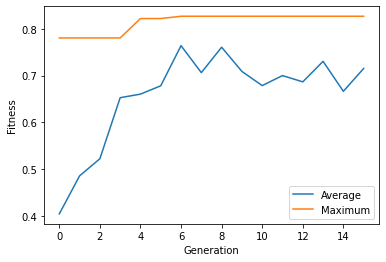

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline  

#Show generational plot
gen, avg, max_ = log.select("gen", "avg", "max")
plt.plot(gen, avg, label="Average")
plt.plot(gen, max_, label="Maximum")
plt.xlabel("Generation")
plt.ylabel("Fitness")
plt.legend(loc="lower right")
plt.show()

In [ ]:
#Print best score and individual
print(f'Best Individual:\n{hof[0]}')
print(f'Fitness: {seen_models[str(hof[0])]}')

Best Individual:
[7, 1, 7, 1, 5, 7]
Fitness: 0.8266718456410842


Model Info:
Transfer Learning Base: VGG16
Activation Type: tanh
Optimizer Type: sgd
Number of Trainable Layers: 27
Number of Fully-Connected Layers: 7 (not including output layer)
Dropout Chance: 0.07692307692307693

Model Report:
              precision    recall  f1-score   support

           0       0.89      0.75      0.81       642
           1       0.74      0.87      0.80       387
           2       0.86      0.96      0.91       245

    accuracy                           0.83      1274
   macro avg       0.83      0.86      0.84      1274
weighted avg       0.84      0.83      0.83      1274



Plot:


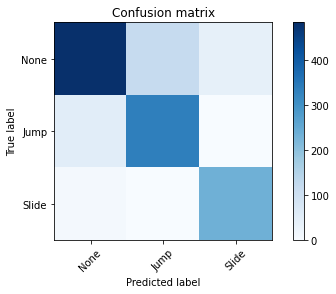

In [39]:
chromosome = [7, 1, 7, 1, 5, 7]

def get_activation_type(x):
  if x % 3 == 0:
    return 'relu'
  elif x % 3 == 1:
    return 'tanh'
  else:
    return 'sigmoid'

def get_optimizer_type(x):
  if x % 2 == 0:
    return 'adam'
  else:
    return 'sgd'

def get_base(x):
  if x % 2 == 0:
    return 'MobileNet'
  else:
    return 'VGG16'

model = tf.keras.models.load_model(f'/content/drive/MyDrive/CSC180_Final_Project/Transfer_Learning_Models/717157/')

# Print model info
print('Model Info:')
print(f'Transfer Learning Base: {get_base(chromosome[5])}')
print(f'Activation Type: {get_activation_type(chromosome[1])}')
print(f'Optimizer Type: {get_optimizer_type(chromosome[0])}')
print(f'Number of Trainable Layers: {len(model.layers) - chromosome[2]}')
print(f'Number of Fully-Connected Layers: {chromosome[4] + 2} (not including output layer)')
print(f'Dropout Chance: {float(chromosome[3])/float(13)}\n')

# Predict
pred = model.predict(x_test)
pred = np.argmax(pred, axis=1)
y_true = np.argmax(y_test, axis=1)

# Report
print('Model Report:')
print(metrics.classification_report(y_true, pred, zero_division=1))
print('\n')

# Plot
print('Plot:')
cm = confusion_matrix(y_true, pred)
plt.figure()
plot_confusion_matrix(cm, label_decoder)

## INFO: Panda Runner
Unfortunately it is impossible to include all the game files in this notebook. As a result I have included a link to the GitHub repository that hosts it. In that repository you will find a detailed <u>ReadMe</u> that outlines the results of the models in the actual game, and how to run/play the game along with various other features. However, if you are just interested in seeing what it can do, I have linked a video below where our best model plays Panda Runner!<br>

### GitHub Repository: <a href="https://github.com/Warthog710/CSC180-Final-Platformer">Panda Runner Repository</a><br>
### YouTube Video: <a href="https://youtu.be/30g_3F2pwN8">Panda Runner - AI Run (3.38x Speed)</a>